In [1]:
# start julia in terminal with export JULIA_NUM_THREADS=5
# change path e.g. "cd("./Documents/Github/Multi_NNGP/RDA/projects/Conj/")"
# run code line by line

# This file is for illustration, the RDA results are presented in the paper

In [2]:
using Distributions
using Random
using Distances
using LinearAlgebra
using SparseArrays
using IterativeSolvers
using ProgressMeter
using JLD2
using DataFrames
using Dates

In [2]:
include("../../../util2.j")

colnorm (generic function with 1 method)

In [3]:
Sys.free_memory()/(2^20*1024)

17.79863739013672

In [4]:
@load "../../data/conj_data/conj_data_expanded.jld"

┌ Warning: type OrderedCollections.OrderedDict{Symbol,Any} does not exist in workspace; reconstructing
└ @ JLD2 /home/lu/.julia/packages/JLD2/KjBIK/src/data.jl:1153


24-element Array{Symbol,1}:
 :U_indx      
 :S_indx      
 :N           
 :n           
 :m           
 :NN          
 :nnIndx_col  
 :nnIndx_row  
 :NM          
 :MnnIndxLU   
 :MnnIndx     
 :Mnndists    
 :coords      
 :coords_pred 
 :CVNN_train  
 :CVnnIndx_col
 :CVnnIndx_row
 :CVNN_test   
 :CVMnnIndxLU 
 :CVMnnIndx   
 :CVMnndists  
 :parts_train 
 :parts_test  
 :kf          

In [ ]:
using RData
@time data_cleaned = load("../../data/rawdata/cleaned_data2_expanded.RData", convert = true)["data_cleaned2"];
@time hold_index_set = load("../../data/rawdata/hold_index_expanded.RData", convert = true);

In [6]:
DataFrames.describe(data_cleaned)

,variable,mean,min,median,max
,Symbol,Float64,Float64,Float64,Float64
1,x,-1.04265e7,-1.11193e7,-1.03937e7,-1.00078e7
2,y,3.83719e6,3.33608e6,3.81747e6,4.44757e6
3,scaled_x,0.692742,0.0,0.725548,1.11149
4,scaled_y,0.501102,0.0,0.481382,1.11149
5,NDVI,0.240135,-0.00954541,0.192437,0.666598
6,EVI,0.15018,-0.00410843,0.122129,0.618208
7,red_reflectance,0.144423,0.0031,0.1452,0.3997
8,NIR_reflectance,0.243497,0.005,0.2383,0.6276
9,blue_reflectance,0.0752172,0.0001,0.0754,0.2


In [7]:
Y_ord = convert(Matrix, data_cleaned[:, [:NDVI, :red_reflectance]]);
X_ord = dropzeros(sparse([fill(1.0, (N, 1)) convert(Matrix, data_cleaned[:, 28:28])]));
p = 2; q = 2; K = 2;

In [25]:
data_cleaned = nothing; hold_index_set = nothing; GC.gc();

In [8]:
# priors #
μβ = fill(0.0, p, q); inv_Vr = fill(0.0, p, p); # set Vr^{-1} be zero for the simulation...
νΣ = q + 1; ΨΣ = [[1.0 0.0]; [0.0 1.0]];
inv_Lr = fill(0.0, p, p); Lμβ = inv_Lr * μβ;

In [36]:
# (a) grid of candidate value
ϕ_grid = LinRange(3 / sqrt(2), 3 * 100 / (4 * sqrt(2)), 2); #LinRange(3 / sqrt(2), 3 * 100 / sqrt(2), 10);#[60.128]#vcat(LinRange(128, 212, 5))
#LinRange(3 / sqrt(2), 3 * 100 / sqrt(2), 8)
α_grid = LinRange(0.90, 0.99999, 2);#LinRange(0.6, 0.999, 20);#[0.99]#vcat(LinRange(0.98, 0.999, 3)) 

In [39]:
using Base.Threads
println("Number of threads = $(nthreads())")

Number of threads = 1


In [40]:
Dates.format(now(), "HH:MM:SS") 

"23:28:34"

In [41]:
# For loop
CVRMSPE_i = fill(0.0, length(ϕ_grid), length(α_grid), kf);
prog = Progress(kf, 1, "Computing initial pass...", 50)
@time Threads.@threads for i in 1:kf
    print(Threads.threadid());
    CVnIndx = length(CVNN_train[i].nnIndx);
    nk = length(parts_test[i]);
    CVA = Array{Float64}(undef, CVnIndx); CVD = Array{Float64}(undef, n - nk);
    CVVK = []; CVXstar = []; CVYstar = []; CVμstar = [];
    
    CVAtilde = Array{Float64}(undef, nk * m); CVDtilde = Array{Float64}(undef, nk);
    CVAtildeM = [];
    
@time    for j in 1:length(ϕ_grid) 
        getAD(coords[parts_train[i], :], CVNN_train[i].nnIndx, CVNN_train[i].nnDist, 
            CVNN_train[i].nnIndxLU, ϕ_grid[j], 0.5, CVA, CVD);
        CVVK = Diagonal(1 ./ sqrt.(CVD)) * (sparse(CVnnIndx_row[i], 
                CVnnIndx_col[i], vcat(-CVA, ones(n - nk))));
        
        getAD(coords[parts_train[i], :], CVMnnIndx[i], 
                CVMnndists[i], CVMnnIndxLU[i],  ϕ_grid[j], 0.5, CVAtilde, CVDtilde);
        CVAtildeM = sparse(repeat(1:nk, inner = m), CVMnnIndx[i], CVAtilde, nk, n - nk);
        for k in 1:length(α_grid)
            
            # obtain posterior estimators of beta
            
            CVa = sqrt(α_grid[k] / (1 - α_grid[k]));
            CVXstar = sparse(vcat(repeat(1:(n - nk), (p + 1)), repeat((n - nk + 1):(n - nk + p), p)), 
                vcat(repeat(1:p, inner = n - nk), (1 + p):(n - nk + p), repeat(1:p, inner = p)), 
                vcat(vec(CVa * X_ord[S_indx[parts_train[i]], :]), CVa * ones(n - nk), 
                    vec(inv_Lr)), (2 * (n - nk) + p), (p + n - nk));
            CVXstar[(n - nk + p + 1): (2 * (n - nk) + p), (p + 1):(n - nk + p)] = CVVK;
            CVYstar = vcat(CVa * Y_ord[S_indx[parts_train[i]], :], Lμβ, fill(0.0, (n - nk, q)));
            CVμstar = fill(0.0, n - nk + p, q)
            for l in 1:q
                CVμstar[:, l] = lsmr(CVXstar, CVYstar[:, l]);
            end

            # obtain posterior predictions over holded folder
            Y_hold_mean = X_ord[S_indx[parts_test[i]], :] * CVμstar[1:p, 1:q] + 
                CVAtildeM * CVμstar[(p + 1):(p + n - nk), 1:q];
            
            # Calculate RMSPE
            CVRMSPE_i[j, k, i] = CVRMSPE_i[j, k, i] + 
            mean((Y_ord[S_indx[parts_test[i]], :] - Y_hold_mean).^2) * (length(parts_test[i]) / n);
        end
    end
end
CVRMSPE = [sqrt(sum(CVRMSPE_i[j, k, :]) ) for j in 1:length(ϕ_grid), k in 1:length(α_grid)];

1 62.128746 seconds (114.64 M allocations: 44.871 GiB, 8.96% gc time)
1 61.228883 seconds (114.64 M allocations: 44.799 GiB, 8.94% gc time)
1 61.912482 seconds (114.64 M allocations: 44.889 GiB, 8.93% gc time)
1 61.742237 seconds (114.64 M allocations: 44.853 GiB, 8.97% gc time)
1 61.736010 seconds (114.64 M allocations: 44.853 GiB, 8.98% gc time)
308.849177 seconds (573.39 M allocations: 225.526 GiB, 8.96% gc time)


In [ ]:
Dates.format(now(), "HH:MM:SS") 

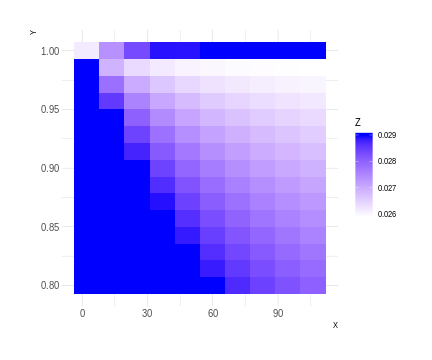

RObject{VecSxp}


In [14]:
# check heatmap of RMSPE over grid #
using RCall
@rput CVRMSPE
@rput ϕ_grid α_grid
R"""
library(ggplot2)
library(hrbrthemes)

# Dummy data
x <- round(ϕ_grid, digits = 4)
y <- round(α_grid, digits = 6)
data <- expand.grid(X=x, Y=y)
#trun_ind = which(CVRMSPE > 0.0211);
#CVRMSPE[trun_ind] = 0.0211 #0.021025
data$Z <- c(CVRMSPE)#[7:19, 6:18] 

ggplot(data, aes(X, Y, fill= Z)) + 
  geom_tile() +
  scale_fill_gradient(low="white", high="blue") + theme_ipsum()
"""

In [11]:
# cross-validation for choosing delta and phi ...
pick_ind = argmin(CVRMSPE);
ϕ_pick = ϕ_grid[pick_ind[1]]; α_pick = α_grid[pick_ind[2]]; # alpha ranges from 0 to 1. alpha = sigma2 / (sigma2 + tau2)
[ϕ_pick, α_pick]

2-element Array{Float64,1}:
 106.06601717798212
   0.985705        

In [9]:
ϕ_pick = 20.175501251534527; α_pick = 0.999551052631579;

In [20]:
# Build μ* V* Ψ* v*

# (a) Lr-1 and Lr-1μβ

# (b) Construct Xstar Ystar
nIndx = length(NN.nnIndx);
A = Array{Float64}(undef, nIndx); D = Array{Float64}(undef, n);
getAD(coords, NN.nnIndx, NN.nnDist, NN.nnIndxLU, ϕ_pick, 0.5, A, D);
VK = Diagonal(1 ./ sqrt.(D)) * (sparse(nnIndx_row, nnIndx_col, vcat(-A, ones(n))));
a = sqrt(α_pick / (1 - α_pick));
Xstar = sparse(vcat(repeat(1:n, p + 1), repeat((n + 1):(n + p), p)), 
        vcat(repeat(1:p, inner = n), (1 + p):(n + p), repeat(1:p, inner = p)), 
        vcat(vec(a * X_ord[S_indx, :]), a * ones(n), vec(inv_Lr)), (2 * n + p), (p + n));
Xstar[(n + p + 1): (2 * n + p), (p + 1):(n + p)] = VK;
Ystar = vcat(a * Y_ord[S_indx, :], Lμβ, fill(0.0, (n, q)));
# (c) obtain μstar ψstar and νstar
μstar = fill(0.0, n + p, q)
for i in 1:q
    μstar[:, i] = lsmr(Xstar, Ystar[:, i]);
end
u = Ystar - Xstar * μstar;
Ψstar = ΨΣ + u'u; νstar = νΣ + n;


In [16]:
# construct Atilde Dtilde #

Atilde = Array{Float64}(undef, NM * m); Dtilde = Array{Float64}(undef, NM);
getAD(coords, MnnIndx, Mnndists, MnnIndxLU, ϕ_pick, 0.5, Atilde, Dtilde)
AtildeM = sparse(repeat(1:NM, inner = m), MnnIndx .+ p, Atilde, NM, n + p);
DtildeD = Diagonal(sqrt.(Dtilde));
lll = fill(1.0, (n, 1)); lllM = fill(1.0, (NM, 1));

In [17]:
Sys.free_memory()/(2^20*1024)

0.3795661926269531

In [45]:
# Preallocation for posterior samples #
N_sam = 500;
β_sam = Array{Float64, 3}(undef, p, q, N_sam);
Σ_sam = Array{Float64, 3}(undef, q, q, N_sam);
cov_ω_sam = Array{Float64, 3}(undef, q, q, N_sam);
γ_sam = Array{Float64, 2}(undef, p + n, q);
ω_sam_mean = zeros(n, q);
ω_sam_var = zeros(n, q);
ω_incp_sam_mean = zeros(n, q);
ω_incp_sam_var = zeros(n, q);
ω_M_sam = Array{Float64, 2}(undef, NM, q);
ω_M_sam_mean = zeros(NM, q);
ω_M_sam_var = zeros(NM, q);
ω_incp_M_sam_mean = zeros(NM, q);
ω_incp_M_sam_var = zeros(NM, q);
Y_M_sam = Array{Float64, 2}(undef, NM, q);   # missing value
Y_M_sam_mean = zeros(NM, q);
Y_M_sam_var = zeros(NM, q);

cholΣ_sam = Array{Float64, 2}(undef, q, q);
eta = fill(0.0, (2 * n + p, q)); v = fill(0.0, (n + p, q)); z = fill(0.0, (NM, q));

In [46]:
# generate the posterior samples #
Random.seed!(123);
prog = Progress(N_sam, 1, "Computing initial pass...", 50)
#@time Threads.@threads 
for l in 1:N_sam
    
    Σ_sam[:, :, l] = rand(InverseWishart(νstar, Ψstar), 1)[1];    # sample Σ
    cholΣ_sam = cholesky(Σ_sam[:, :, l]);
    eta = rand(Normal(), 2 * n + p, q) * cholΣ_sam.U;
    for i in 1:q
        v[:, i] = lsmr(Xstar, eta[:, i]);
    end
    γ_sam = v + μstar;
    β_sam[:, :, l] = γ_sam[1:p, :];
    cov_ω_sam[:, :, l] = cov(γ_sam[(p + 1):(p + n), :]);
    ω_sam_mean[:, :] = ω_sam_mean[:, :] + γ_sam[(p + 1):(p + n), :] ./ N_sam;
    ω_sam_var[:, :] = ω_sam_var[:, :] + γ_sam[(p + 1):(p + n), :].^2 ./ N_sam;
    ω_incp_sam_var[:, :] = ω_incp_sam_var[:, :] + (γ_sam[(p + 1):(p + n), :] + 
        lll * transpose(γ_sam[1, :])).^2 ./ N_sam;
    
    ω_M_sam[:, :] = AtildeM * γ_sam + DtildeD * (rand(Normal(), NM, q) * cholΣ_sam.U);
    ω_M_sam_mean[:, :] = ω_M_sam_mean[:, :] + ω_M_sam ./ N_sam;
    ω_M_sam_var[:, :] = ω_M_sam_var[:, :] + ω_M_sam.^2 ./ N_sam;
    ω_incp_M_sam_var[:, :] = ω_incp_M_sam_var[:, :] + 
    (ω_M_sam + lllM * transpose(γ_sam[1, :])).^2 ./ N_sam;
    
    z = rand(Normal(), NM, q) * cholΣ_sam.U;
    Y_M_sam[:, :] = X_ord[U_indx, :] * γ_sam[1:p, 1:q] + ω_M_sam + 1 / a * z;
    Y_M_sam_mean[:, :] = Y_M_sam_mean[:, :] + Y_M_sam ./ N_sam;
    Y_M_sam_var[:, :] = Y_M_sam_var[:, :] + Y_M_sam.^2 ./ N_sam;

    GC.gc();
    next!(prog) # monitor the progress
end

Computing initial pass...100%|██████████████████████████████████████████████████| Time: 0:00:31


| Time: 0:18:53

In [47]:
ω_sam_var = (ω_sam_var - ω_sam_mean.^2) * (N_sam / (N_sam - 1));
ω_M_sam_var = (ω_M_sam_var - ω_M_sam_mean.^2) * (N_sam / (N_sam - 1));
ω_incp_sam_mean = ω_sam_mean + lll * transpose([mean(β_sam[1, i, :]) for i in 1:p]);
ω_incp_sam_var = (ω_incp_sam_var - ω_incp_sam_mean.^2) * (N_sam / (N_sam - 1));
ω_incp_M_sam_mean = ω_M_sam_mean + lllM * transpose([mean(β_sam[1, i, :]) for i in 1:p]);
ω_incp_M_sam_var = (ω_incp_M_sam_var - ω_incp_M_sam_mean.^2) * (N_sam / (N_sam - 1));

Y_M_sam_var = (Y_M_sam_var - Y_M_sam_mean.^2) * (N_sam / (N_sam - 1));             

In [60]:
using JLD2
@save "../../results/conj/Multi_conj_latent_data.jld" p q N_sam Y_ord β_sam Σ_sam cov_ω_sam ω_sam_mean ω_sam_var ω_incp_sam_mean ω_incp_sam_var ω_M_sam_mean ω_M_sam_var ω_incp_M_sam_mean ω_incp_M_sam_var Y_M_sam_mean Y_M_sam_var ϕ_pick α_pick